In [39]:
import pandas as pd
import numpy as np
import re

In [44]:
df = pd.read_csv('./performance_data_proc.csv')

In [45]:
df = df.replace({',': '.'}, regex=True)
df = df.iloc[:, 1:]


In [46]:
df_pca_cluster = df.filter(regex='^(Principale|Cluster)')
df_pca_cluster = df_pca_cluster.apply(pd.to_numeric, errors='coerce')


In [50]:
df_varianza = pd.read_csv('./num_pca_varianza_conservata.csv', sep=';')
lista_numero_pca = df_varianza['num_pca'].to_list()
lista_varianze = df_varianza['varianza_conservata'].to_list()

df_varianza_dict = df_varianza.set_index('num_pca')['varianza_conservata'].to_dict()

In [51]:
df_pca = df.filter(regex='^Principale')
# Converto tutte le colonne in numeriche, forzando gli errori a NaN (in caso ci siano valori non numerici)
df_pca = df_pca.apply(pd.to_numeric, errors='coerce')

In [52]:
# Calcolo devianza totale
devianze_totali_per_pca = []

for val in lista_numero_pca:
    # Vado a calcolare il centroide andando a considerare solo le prime i componenti princiali
    df_pca_selezionato = df_pca.iloc[:, :val]
    centroide = df_pca_selezionato.mean()
    # (df_pca_selezionato - centroide) è il dataframe con le differenze di ogni riga dal centroide
    # (df_pca_selezionato - centroide)**2 mi eleva tutto al quadrato
    # .sum() fa la somma degli elementi della riga
    # .sum() somma tutti i valori tra loro
    devianza = ((df_pca_selezionato - centroide)**2).sum().sum()
    devianze_totali_per_pca.append({val: devianza}) 

print(devianze_totali_per_pca)   

[{7: 102428.99318066557}, {8: 109329.36738688828}, {9: 115743.32120913797}, {10: 119385.1467072363}, {11: 122908.4840796958}, {12: 125361.77774570233}, {13: 127054.7701585568}]


In [53]:
# Calcolo devianza intercluster

devianze_inter_cluster = []

for col in df_pca_cluster:
    match = re.match(r'Cluster(\d+)_(\d+)', col)
    if match:
        num_cluster = int(match.group(1))
        num_pca = int(match.group(2))
        # Seleziono solo le PCA considerate 
        lista_colonne = list(df_pca.columns[:num_pca])
        lista_colonne.append(col)
        df_attuale = df_pca_cluster[lista_colonne]
        
        # Centroide totale
        centroide_totale = df_attuale.iloc[:, :-1].mean(axis=0)
       
        # DataFrame per i centroidi dei cluster
        colonne_centroidi = list(centroide_totale.index) + ['Cluster', 'NumeroElementi']
        df_centroidi = pd.DataFrame(columns=colonne_centroidi)

        for val in df_attuale[col].unique():
            # Filtro per cluster corrente
            df_del_cluster = df_attuale[df_attuale[col] == val]
            # Calcolo centroide del cluster
            centroide_cluster = df_del_cluster.iloc[:, :-1].mean(axis=0).tolist()  # Converti a lista
            # Calcolo numero di elementi del cluster
            num_elementi_del_cluster = df_del_cluster.shape[0]
            # Crea la nuova riga con i valori del centroide, il cluster e il numero di elementi
            nuova_riga = centroide_cluster + [val, num_elementi_del_cluster]
            # Aggiungi la nuova riga al DataFrame
            df_centroidi.loc[len(df_centroidi)] = nuova_riga
        
        #print(df_centroidi)
        devianza = 0
        # Calcolo devianza 
        for val in df_centroidi.iloc[:, -2]:
            riga = df_centroidi[df_centroidi.iloc[:, -2] == val]
            #print(riga)
            num = riga.iloc[0, -1]
            #print(num)
            riga = riga.iloc[:, :-2]  
        
            devianza = devianza + num * (((riga - centroide_totale)**2).sum().sum())
            
        devianze_inter_cluster.append((num_cluster, num_pca, devianza))
        
print(devianze_inter_cluster)

[(5, 7, 30900.030842733937), (10, 7, 58870.79072275094), (15, 7, 70337.39658730711), (25, 7, 79148.66719151079), (5, 8, 33510.94138582385), (10, 8, 63667.26447373829), (15, 8, 75867.9077169489), (25, 8, 83865.63629209073), (5, 9, 38546.36956031967), (10, 9, 63228.75964094369), (15, 9, 76904.34544428223), (25, 9, 86585.49340115205), (5, 10, 37439.18459559178), (10, 10, 59597.76011847158), (15, 10, 75499.87381952816), (25, 10, 88145.50695027605), (5, 11, 37461.85403855149), (10, 11, 56599.646168370804), (15, 11, 74261.43008617047), (25, 11, 86564.20938448318), (5, 12, 32263.311306496063), (10, 12, 52138.45516611357), (15, 12, 72785.13132791416), (25, 12, 86877.90740133112), (5, 13, 33521.76799222168), (10, 13, 56003.7656988307), (15, 13, 72037.55478283661), (25, 13, 84090.83459054946)]


In [54]:
devianze_totali_per_pca_dict = {k: v for d in devianze_totali_per_pca for k, v in d.items()}

In [55]:
print("Devianze inter cluster:")
print(devianze_inter_cluster)

print("Devianze totale")
print(devianze_totali_per_pca_dict)

devianze_intra_cluster = []

for num_cluster, num_pca, devianza_inter in devianze_inter_cluster:
    devianza_totale = devianze_totali_per_pca_dict[num_pca]
    devianze_intra_cluster.append((num_cluster, num_pca, devianza_totale - devianza_inter))
    
print("Devianze intra cluster")
print(devianze_intra_cluster)
    


Devianze inter cluster:
[(5, 7, 30900.030842733937), (10, 7, 58870.79072275094), (15, 7, 70337.39658730711), (25, 7, 79148.66719151079), (5, 8, 33510.94138582385), (10, 8, 63667.26447373829), (15, 8, 75867.9077169489), (25, 8, 83865.63629209073), (5, 9, 38546.36956031967), (10, 9, 63228.75964094369), (15, 9, 76904.34544428223), (25, 9, 86585.49340115205), (5, 10, 37439.18459559178), (10, 10, 59597.76011847158), (15, 10, 75499.87381952816), (25, 10, 88145.50695027605), (5, 11, 37461.85403855149), (10, 11, 56599.646168370804), (15, 11, 74261.43008617047), (25, 11, 86564.20938448318), (5, 12, 32263.311306496063), (10, 12, 52138.45516611357), (15, 12, 72785.13132791416), (25, 12, 86877.90740133112), (5, 13, 33521.76799222168), (10, 13, 56003.7656988307), (15, 13, 72037.55478283661), (25, 13, 84090.83459054946)]
Devianze totale
{7: 102428.99318066557, 8: 109329.36738688828, 9: 115743.32120913797, 10: 119385.1467072363, 11: 122908.4840796958, 12: 125361.77774570233, 13: 127054.7701585568}
De

In [58]:
lista_finale = []

for num_cluster, num_pca, devianza_inter in devianze_inter_cluster:
    devianza_totale = devianze_totali_per_pca_dict[num_pca]
    inter_percentuale = devianza_inter/devianza_totale
    intra_percentuale = (devianza_totale - devianza_inter)/devianza_totale
    devianza_persa = 1 - inter_percentuale*df_varianza_dict[num_pca]

    lista_finale.append((num_cluster, num_pca, inter_percentuale, intra_percentuale, devianza_persa))


lista_dizionari = [
    {
        "num_cluster": num_cluster,
        "num_pca": num_pca,
        "intra_cluster_deviance": intra_percentuale,
        "inter_cluster_deviance": inter_percentuale,
        "devianza_persa": devianza_persa
    }
    for num_cluster, num_pca, inter_percentuale, intra_percentuale, devianza_persa in lista_finale
]

print(lista_dizionari)

[{'num_cluster': 5, 'num_pca': 7, 'intra_cluster_deviance': 0.698327300862637, 'inter_cluster_deviance': 0.30167269913736305, 'devianza_persa': 0.7616785676814832}, {'num_cluster': 10, 'num_pca': 7, 'intra_cluster_deviance': 0.4252526663137859, 'inter_cluster_deviance': 0.5747473336862141, 'devianza_persa': 0.5459496063878908}, {'num_cluster': 15, 'num_pca': 7, 'intra_cluster_deviance': 0.31330578966792033, 'inter_cluster_deviance': 0.6866942103320797, 'devianza_persa': 0.45751157383765706}, {'num_cluster': 25, 'num_pca': 7, 'intra_cluster_deviance': 0.2272825814864024, 'inter_cluster_deviance': 0.7727174185135975, 'devianza_persa': 0.3895532393742579}, {'num_cluster': 5, 'num_pca': 8, 'intra_cluster_deviance': 0.6934863688798516, 'inter_cluster_deviance': 0.30651363112014834, 'devianza_persa': 0.7425285498590755}, {'num_cluster': 10, 'num_pca': 8, 'intra_cluster_deviance': 0.4176563352055596, 'inter_cluster_deviance': 0.5823436647944403, 'devianza_persa': 0.5108313215726701}, {'num_cl

In [59]:
# Creiamo una tabella con i valori ottenuti
new_df = pd.DataFrame(lista_dizionari)
new_df["row_name"] = new_df.apply(lambda row: f"PCA: {row['num_pca']}, Cluster: {row['num_cluster']}", axis=1)
new_df = new_df.drop(columns=["num_cluster", "num_pca"])
new_df = new_df.set_index("row_name")
new_df.to_csv("tabella_deviance.csv", index=True)

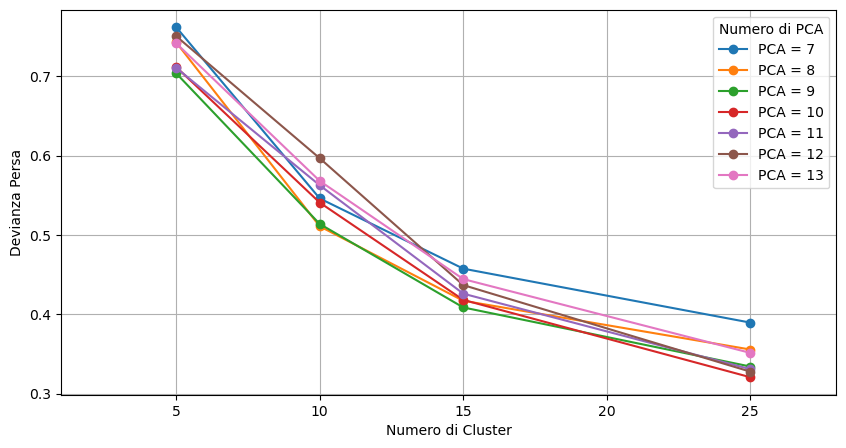

In [60]:
import matplotlib.pyplot as plt
# Grafici

pca_values = sorted(set(d["num_pca"] for d in lista_dizionari))
cluster_values = sorted(set(d["num_cluster"] for d in lista_dizionari))

# Grafico devianza persa
plt.figure(figsize=(10, 5))

for pca in pca_values:
    x_values = [d["num_cluster"] for d in lista_dizionari if d["num_pca"] == pca]
    y_values = [d["devianza_persa"] for d in lista_dizionari if d["num_pca"] == pca]
    
    plt.plot(x_values, y_values, label=f'PCA = {pca}', marker='o')

plt.xlim(1, max(cluster_values) + 3)  # Correzione qui
plt.xlabel('Numero di Cluster')
plt.ylabel('Devianza Persa')
plt.legend(title="Numero di PCA")
plt.grid(True)
plt.show()


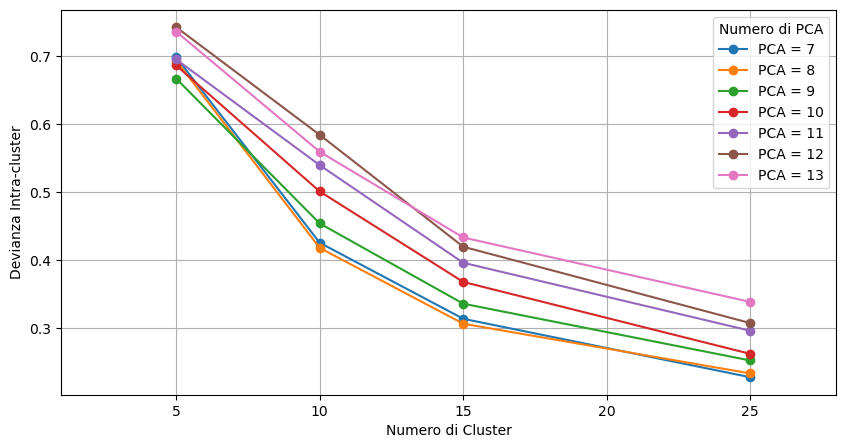

In [61]:
# Grafico devianza intra cluster
plt.figure(figsize=(10, 5))

for pca in pca_values:
    x_values = [d["num_cluster"] for d in lista_dizionari if d["num_pca"] == pca]
    y_values = [d["intra_cluster_deviance"] for d in lista_dizionari if d["num_pca"] == pca]
    
    plt.plot(x_values, y_values, label=f'PCA = {pca}', marker='o')

plt.xlim(1, max(cluster_values) + 3)  # Correzione qui
plt.xlabel('Numero di Cluster')
plt.ylabel('Devianza Intra-cluster')
plt.legend(title="Numero di PCA")
plt.grid(True)
plt.show()

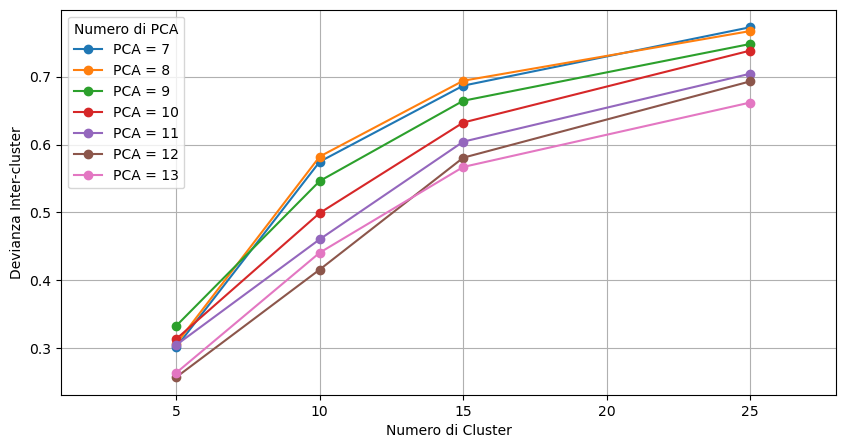

In [62]:
# Grafico devianza intercluster
plt.figure(figsize=(10, 5))

for pca in pca_values:
    x_values = [d["num_cluster"] for d in lista_dizionari if d["num_pca"] == pca]
    y_values = [d["inter_cluster_deviance"] for d in lista_dizionari if d["num_pca"] == pca]
    
    plt.plot(x_values, y_values, label=f'PCA = {pca}', marker='o')

plt.xlim(1, max(cluster_values) + 3)  # Correzione qui
plt.xlabel('Numero di Cluster')
plt.ylabel('Devianza Inter-cluster')
plt.legend(title="Numero di PCA")
plt.grid(True)
plt.show()

In [22]:
# Calcolo devianza persa senza PCA
cols_to_drop = [col for col in df.columns if 'Principale' in col or 'Cluster' in col and 'ClusterNOPCA' not in col]
df_senza_pca = df.drop(columns=cols_to_drop)

# Inserire qui le colonne non considerate in fase di analisi
cols_da_eliminare = []
df_senza_pca = df_senza_pca.drop(columns=cols_da_eliminare)
df_senza_pca = df_senza_pca.apply(pd.to_numeric, errors='coerce')

In [23]:
# Devianza totale
devianza_totale = 0
df_senza_cluster = df_senza_pca.drop(columns=[col for col in df_senza_pca.columns if 'Cluster' in col], errors='ignore')
centroide = df_senza_cluster.mean()
devianza_totale = ((df_senza_cluster - centroide)**2).sum().sum()


In [24]:
# Calcolo devianza intercluster
num_componenti = 0
devianze_inter_cluster = []

for col in df_senza_pca:
    match = re.match(r'ClusterNOPCA_(\d+)', col)
    if match:
        num_cluster = int(match.group(1))
        # Seleziono solo le PCA considerate 
        lista_colonne = list(df_senza_pca.columns[:num_componenti])
        lista_colonne.append(col)
        df_attuale = df_senza_pca[lista_colonne]
        
        # Centroide totale
        centroide_totale = df_attuale.iloc[:, :-1].mean(axis=0)
        
        # DataFrame per i centroidi dei cluster
        colonne_centroidi = list(centroide_totale.index) + ['Cluster', 'NumeroElementi']
        df_centroidi = pd.DataFrame(columns=colonne_centroidi)

        for val in df_attuale[col].unique():
            # Filtro per cluster corrente
            df_del_cluster = df_attuale[df_attuale[col] == val]
            # Calcolo centroide del cluster
            centroide_cluster = df_del_cluster.iloc[:, :-1].mean(axis=0).tolist()  # Converti a lista
            # Calcolo numero di elementi del cluster
            num_elementi_del_cluster = df_del_cluster.shape[0]
            # Crea la nuova riga con i valori del centroide, il cluster e il numero di elementi
            nuova_riga = centroide_cluster + [val, num_elementi_del_cluster]
            # Aggiungi la nuova riga al DataFrame
            df_centroidi.loc[len(df_centroidi)] = nuova_riga

        devianza = 0
        # Calcolo devianza 
        for val in df_centroidi.iloc[:, -2]:
            riga = df_centroidi[df_centroidi.iloc[:, -2] == val]
            
            num = riga.iloc[0, -1]
            #print(num)
            riga = riga.iloc[:, :-2]  
        
            devianza = devianza + num * (((riga - centroide_totale)**2).sum().sum())
            
        devianze_inter_cluster.append((num_cluster, devianza))
    
    else:
        num_componenti = num_componenti + 1



In [25]:
devianze_intra_cluster = []

for num_cluster, devianza_inter in devianze_inter_cluster:
    devianze_intra_cluster.append((num_cluster, devianza_totale - devianza_inter))


In [26]:
print("Devianza totale")
print(devianza_totale)

print("Devianze inter cluster")
print(devianze_inter_cluster)

print("Devianze intra cluster")
print(devianze_intra_cluster)

Devianza totale
1.1808351443794957e+17
Devianze inter cluster
[(5, 5.230241651555002e+16), (10, 6.673118110311557e+16), (15, 7.805310579557811e+16), (25, 8.33900394895367e+16)]
Devianze intra cluster
[(5, 6.578109792239955e+16), (10, 5.1352333334834e+16), (15, 4.003040864237146e+16), (25, 3.4693474948412864e+16)]


In [32]:
lista_finale = []

for num_cluster, devianza_inter in devianze_inter_cluster:
    inter_percentuale = devianza_inter/devianza_totale
    intra_percentuale = (devianza_totale - devianza_inter)/devianza_totale
    devianza_persa = 1 - inter_percentuale

    lista_finale.append((num_cluster, num_pca, inter_percentuale, intra_percentuale, devianza_persa))


lista_dizionari = [
    {
        "num_cluster": num_cluster,
        "intra_cluster_deviance": intra_percentuale,
        "inter_cluster_deviance": inter_percentuale,
        "devianza_persa": devianza_persa
    }
    for num_cluster, num_pca, inter_percentuale, intra_percentuale, devianza_persa in lista_finale
]

print(lista_dizionari)

[{'num_cluster': 5, 'intra_cluster_deviance': 0.5570726636609902, 'inter_cluster_deviance': 0.4429273363390099, 'devianza_persa': 0.5570726636609902}, {'num_cluster': 10, 'intra_cluster_deviance': 0.43488147841177766, 'inter_cluster_deviance': 0.5651185215882224, 'devianza_persa': 0.4348814784117776}, {'num_cluster': 15, 'intra_cluster_deviance': 0.33900082355193284, 'inter_cluster_deviance': 0.6609991764480672, 'devianza_persa': 0.33900082355193284}, {'num_cluster': 25, 'intra_cluster_deviance': 0.2938045595403037, 'inter_cluster_deviance': 0.7061954404596963, 'devianza_persa': 0.2938045595403037}]


In [28]:
# Creiamo una tabella con i valori ottenuti
new_df = pd.DataFrame(lista_dizionari)
new_df["row_name"] = new_df.apply(lambda row: f"Cluster: {row['num_cluster']}", axis=1)
new_df = new_df.drop(columns=["num_cluster"])
new_df = new_df.set_index("row_name")
new_df.to_csv("tabella_deviance_senza_pca.csv", index=True)

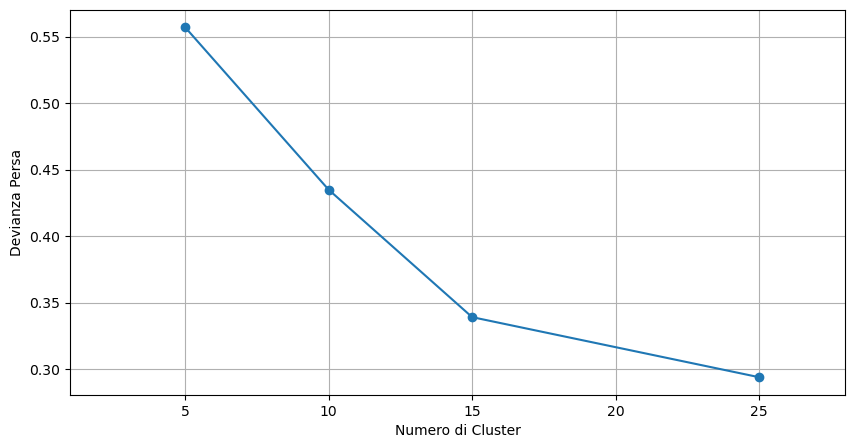

In [29]:
cluster_values = sorted(set(d["num_cluster"] for d in lista_dizionari))

# Grafico devianza persa
plt.figure(figsize=(10, 5))

x_values = [d["num_cluster"] for d in lista_dizionari]
y_values = [d["devianza_persa"] for d in lista_dizionari]
    
plt.plot(x_values, y_values, marker='o')

plt.xlim(1, max(cluster_values) + 3)  # Correzione qui
plt.xlabel('Numero di Cluster')
plt.ylabel('Devianza Persa')
plt.grid(True)
plt.show()


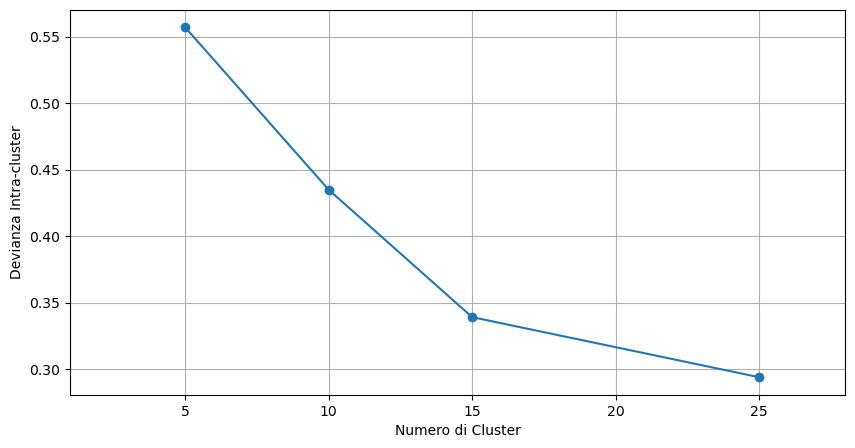

In [30]:
# Grafico devianza intra cluster
plt.figure(figsize=(10, 5))

x_values = [d["num_cluster"] for d in lista_dizionari]
y_values = [d["intra_cluster_deviance"] for d in lista_dizionari]
    
plt.plot(x_values, y_values, marker='o')

plt.xlim(1, max(cluster_values) + 3)  # Correzione qui
plt.xlabel('Numero di Cluster')
plt.ylabel('Devianza Intra-cluster')
plt.grid(True)
plt.show()

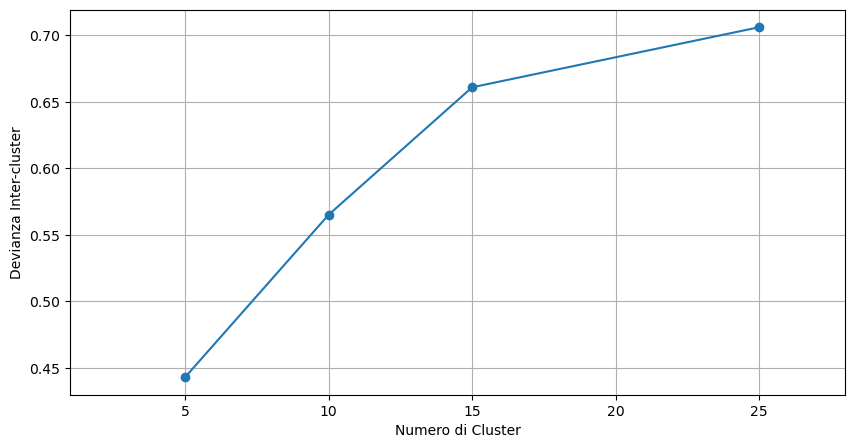

In [31]:
# Grafico devianza inter cluster
plt.figure(figsize=(10, 5))

x_values = [d["num_cluster"] for d in lista_dizionari]
y_values = [d["inter_cluster_deviance"] for d in lista_dizionari]
    
plt.plot(x_values, y_values, marker='o')

plt.xlim(1, max(cluster_values) + 3)  # Correzione qui
plt.xlabel('Numero di Cluster')
plt.ylabel('Devianza Inter-cluster')
plt.grid(True)
plt.show()